# Pip Installs and Connect the Drive

In [ ]:
!pip install transformers
!pip install datasets
!pip install pandas

import os
import sys
from google.colab import drive

device='cuda'
drive.mount('/content/drive')
drive_path = 'wav2vec2_final'
final = os.path.join('drive', 'My Drive', drive_path)
print(os.listdir(final))
sys.path.append(final)

file_path = final + '/dataaudio'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 27.5 MB/s 
     |████████████████████████████████| 163 kB 63.0 MB/s 
     |████████████████████████████████| 7.6 MB 51.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 10.7 MB/s 
     |████████████████████████████████| 115 kB 12.2 MB/s 
     |████████████████████████████████| 95 kB 1.2 MB/s 
     |████████████████████████████████| 212 kB 12.1 MB/s 
     |████████████████████████████████| 127 kB 38.8 MB/s 
     |████████████████████████████████| 115 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully un

# Forming the Dataset

In [ ]:
import numpy
import librosa
import torch
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

paths = []
arr = []
text = []

file_path = final + '/dataaudio'

In [ ]:
for i in range(40):
  paths.append(file_path + f'/{i+1}.wav')

file = file_path + '/text.txt'
with open(file) as f:
    transcription = f.readlines()
f.close()

In [ ]:
for i in range(40):
  transcription[i] = transcription[i].strip('\n')
   #text.append(transcription[i])
  temp,_ = librosa.load(paths[i])
  arr.append(temp)

dataset = {'array': arr, 
           'sampling_rate': 16000, 
           'path': paths, 
           'transcription': transcription
           }

df = pd.DataFrame(dataset)
dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size = 0.2, shuffle=False)

# Construct the pre_trained model processor
*Constructs a Wav2Vec2 processor which wraps a Wav2Vec2 feature extractor and a Wav2Vec2 CTC tokenizer into a single processor.*

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

# Forming Data Collator

In [ ]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

def prepare_dataset(batch):
    batch["input_values"] = processor(batch["array"], sampling_rate=batch["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids
    return batch

dataset = dataset.map(prepare_dataset, num_proc=4)

@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch
        
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

#0:   0%|          | 0/8 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#1:   0%|          | 0/8 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#2:   0%|          | 0/8 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#3:   0%|          | 0/8 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#0:   0%|          | 0/2 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#1:   0%|          | 0/2 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#2:   0%|          | 0/2 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


#3:   0%|          | 0/2 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  "`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your "


# Constructing and Training the model
*Wav2Vec2ForCTC is used to instantiate a Wav2Vec2 model according to the specified arguments, defining the model architecture. Since the base model is pre-trained on 16 kHz audio, we must make sure our audio sample is also resampled to a 16 kHz sampling rate.*

In [ ]:
from transformers import Wav2Vec2ForCTC, TrainingArguments, Trainer

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

training_args = TrainingArguments(
    output_dir="./results",
    group_by_length=True,
    per_gpu_train_batch_size=8,
    evaluation_strategy="steps",
    num_train_epochs=3,
    fp16=True,
    gradient_checkpointing=True,
    learning_rate=1e-3,
    weight_decay=0.005,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
)

torch.cuda.empty_cache()
trainer.train()

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using cuda_amp half precision backend
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: path, input_length, array, transcription, sampling_rate. If path, input_length, array, transcription, sampling_rate are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_train_batch_size` argument w

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=12, training_loss=22.959737141927082, metrics={'train_runtime': 26.0013, 'train_samples_per_second': 3.692, 'train_steps_per_second': 0.462, 'total_flos': 1.175960053942272e+16, 'train_loss': 22.959737141927082, 'epoch': 3.0})

# INFERENCE

In [ ]:
coloumn_selector=1

In [ ]:
audio_input = dataset['test']['array'][coloumn_selector]
input_values = processor(audio_input, sampling_rate = 16000, return_tensors="pt",device='cuda',padding=True).input_values

logits = model(input_values.cuda()).logits
predicted_ids = torch.argmax(logits, dim=-1)

transcription_new = processor.decode(predicted_ids[0])
print("NEW_DECODED: ", transcription_new)
print("")


audioText_new = dataset['test']['transcription'][coloumn_selector]


from difflib import SequenceMatcher
m_n = SequenceMatcher(None, audioText_new, transcription_new)

print("NEW_ACTUAL: ", audioText_new)
print("") 
print ("NEW_ACCURACY = ", m_n.ratio()*100)
print("")


NEW_DECODED:  XXXXXX'

NEW_ACTUAL:  Detailed descriptions of ptychography can be found in a number of earlier publications

NEW_ACCURACY =  0.0



# Old Data Inference

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC

processor_old = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model_old = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

audio_input = dataset['test']['array'][coloumn_selector]
input_values = processor_old(audio_input, sampling_rate = 16000, return_tensors="pt",padding=True).input_values

logits = model_old(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)

transcription = processor_old.decode(predicted_ids[0])

audioText_old = dataset['test']['transcription'][coloumn_selector]


from difflib import SequenceMatcher
m_o = SequenceMatcher(None, audioText_old.upper(), transcription)

print("OLD_DECODED: ", transcription)
print("")
print("OLD_ACTUAL: ", audioText_old)
print("")
print ("OLD_ACCURACY = ", m_o.ratio()*100)





loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--facebook--wav2vec2-base-960h/snapshots/22aad52d435eb6dbaf354bdad9b0da84ce7d6156/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--wav2vec2-base-960h/snapshots/22aad52d435eb6dbaf354bdad9b0da84ce7d6156/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base-960h",
  "activation_dropout": 0.1,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevec

OLD_DECODED:  DETAILED DESCRIPTIONS OF TOCOGRAPHY CAN BE FOUND IN A NUMBER OF EARLIER PUBLICATIONS

OLD_ACTUAL:  Detailed descriptions of ptychography can be found in a number of earlier publications

OLD_ACCURACY =  97.6470588235294


In [ ]:

df = pd.read_csv("/content/drive/MyDrive/wav2vec2_final/dataaudio/speak.csv")
df.loc[df['Sentence'] == audioText_new]

,Sentence,Speaker
33,Detailed descriptions of ptychography can be f...,Speaker1


# Graphical Representation

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
import matplotlib.pyplot as plt
file = open("/content/drive/MyDrive/wav2vec2_final/dataaudio/text.txt")
sample = file.read()
m=len(sample)
token = word_tokenize(sample)

In [ ]:
print(token)
t=len(token)
print(t)

['It', 'is', 'remarkable', 'that', 'multilayered', 'integrated', 'circuits', 'are', 'being', 'manufactured', 'successfully', 'High-resolution', 'coherent', 'diffractive', 'imaging', 'technique', 'can', 'create', 'three-dimensional', 'images', 'of', 'integrated', 'circuits', 'The', 'active', 'transistor', 'layer', 'is', 'at', 'the', 'bottom', 'while', 'other', 'layers', 'mainly', 'consist', 'of', 'metal', 'interconnects', 'The', 'measured', 'structure', 'and', 'design', 'match', 'perfectly', 'The', 'colors', 'of', 'the', 'wires', 'in', 'the', 'schematic', 'are', 'the', 'same', 'as', 'those', 'of', 'the', 'wires', 'used', 'in', 'the', '3D', 'rendering', 'The', 'slice', 'contains', 'the', 'transistor', 'layer', 'where', 'we', 'can', 'identify', 'repetitive', 'structures', 'The', 'tomographic', 'imaging', 'geometry', 'required', 'the', 'extraction', 'of', 'cylindrical', 'pillars', 'from', 'the', 'chips', 'that', 'are', 'initially', 'flat', 'extended', 'objects', 'Xray', 'ptychography', 'pr

In [ ]:
token = word_tokenize(sample)
wlist = []

for i in range(len(token)):
    wlist.append(token[i])

wordfreq = [wlist.count(w) for w in wlist]
print("Pairs\n" + str(zip(token, wordfreq)))

Pairs


In [ ]:
print(wlist)

['It', 'is', 'remarkable', 'that', 'multilayered', 'integrated', 'circuits', 'are', 'being', 'manufactured', 'successfully', 'High-resolution', 'coherent', 'diffractive', 'imaging', 'technique', 'can', 'create', 'three-dimensional', 'images', 'of', 'integrated', 'circuits', 'The', 'active', 'transistor', 'layer', 'is', 'at', 'the', 'bottom', 'while', 'other', 'layers', 'mainly', 'consist', 'of', 'metal', 'interconnects', 'The', 'measured', 'structure', 'and', 'design', 'match', 'perfectly', 'The', 'colors', 'of', 'the', 'wires', 'in', 'the', 'schematic', 'are', 'the', 'same', 'as', 'those', 'of', 'the', 'wires', 'used', 'in', 'the', '3D', 'rendering', 'The', 'slice', 'contains', 'the', 'transistor', 'layer', 'where', 'we', 'can', 'identify', 'repetitive', 'structures', 'The', 'tomographic', 'imaging', 'geometry', 'required', 'the', 'extraction', 'of', 'cylindrical', 'pillars', 'from', 'the', 'chips', 'that', 'are', 'initially', 'flat', 'extended', 'objects', 'Xray', 'ptychography', 'pr

In [ ]:
from numpy.core.fromnumeric import argmax
print(token)
print(wordfreq)
len(wordfreq)

  




['It', 'is', 'remarkable', 'that', 'multilayered', 'integrated', 'circuits', 'are', 'being', 'manufactured', 'successfully', 'High-resolution', 'coherent', 'diffractive', 'imaging', 'technique', 'can', 'create', 'three-dimensional', 'images', 'of', 'integrated', 'circuits', 'The', 'active', 'transistor', 'layer', 'is', 'at', 'the', 'bottom', 'while', 'other', 'layers', 'mainly', 'consist', 'of', 'metal', 'interconnects', 'The', 'measured', 'structure', 'and', 'design', 'match', 'perfectly', 'The', 'colors', 'of', 'the', 'wires', 'in', 'the', 'schematic', 'are', 'the', 'same', 'as', 'those', 'of', 'the', 'wires', 'used', 'in', 'the', '3D', 'rendering', 'The', 'slice', 'contains', 'the', 'transistor', 'layer', 'where', 'we', 'can', 'identify', 'repetitive', 'structures', 'The', 'tomographic', 'imaging', 'geometry', 'required', 'the', 'extraction', 'of', 'cylindrical', 'pillars', 'from', 'the', 'chips', 'that', 'are', 'initially', 'flat', 'extended', 'objects', 'Xray', 'ptychography', 'pr

506

In [ ]:
wordfreq_ind=list(set(zip(token, wordfreq)))

In [ ]:
wordfreq_ind.sort(key = lambda x: x[1], reverse=True)

In [ ]:
print((wordfreq_ind))

[('the', 32), ('The', 18), ('of', 18), ('is', 12), ('a', 11), ('to', 10), ('in', 10), ('and', 8), ('measurement', 8), ('Xray', 6), ('are', 5), ('tomography', 5), ('can', 5), ('for', 5), ('transistor', 4), ('on', 4), ('sample', 4), ('design', 4), ('imaging', 4), ('layers', 4), ('integrated', 4), ('with', 4), ('at', 4), ('were', 4), ('used', 3), ('those', 3), ('that', 3), ('tomographic', 3), ('measured', 3), ('images', 3), (',', 3), ('There', 3), ('geometry', 3), ('match', 3), ('between', 3), ('high', 3), ('laminography', 2), ('resolution', 2), ('structures', 2), ('we', 2), ('identical', 2), ('coherent', 2), ('identify', 2), ('ptychographic', 2), ('not', 2), ('technique', 2), ('inspection', 2), ('holder', 2), ('micromanipulator', 2), ('energy', 2), ('both', 2), ('chip', 2), ('Intel', 2), ('All', 2), ('from', 2), ('foreseeable', 2), ('such', 2), ('perfect', 2), ('map', 2), ('improvements', 2), ('advance', 2), ('circuits', 2), ('diffractive', 2), ('ptychography', 2), ('mount', 2), ('combin

<BarContainer object of 506 artists>

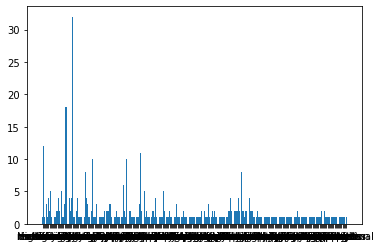

In [ ]:
plt.bar(token, wordfreq)